In [137]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense

from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler


In [138]:
#!wget https://raw.githubusercontent.com/JasonMorris1/CSE151_Tesla_Stock_Prediction/main/tsla_2014_2023.csv
df = pd.read_csv('tsla_2014_2023.csv')
df['date']=pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df = df.drop(columns=['open', 'high', 'low']) # not sure why we do this
#note I didn't drop other columns
df.head()

window  = 90



In [139]:

#df = df.drop(columns=['sma_50', 'sma_100', 'rsi_7', 'ema_50', 'atr_7'], axis=1)

scaler = MinMaxScaler()


df_temp = df.drop(['date'], axis = 1)

df_scale = scaler.fit_transform(df_temp)

df_scaled = pd.DataFrame(df_scale, columns=df_temp.columns)

df_scaled.drop(['year'], axis = 1)
df_scaled['year'] = df['year']


df_scaled['date'] = df['date']
df = df_scaled


df_train1=df[(df.year<2022) & (df.year>2019)]
df_test1=df[(df.year >=2022)]





x_date = df['date']
df_train = df_train1.drop(['date','year','next_day_close'],axis=1)
df_test = df_test1.drop(['date','year','next_day_close'],axis=1)


df_train.head()

df_train = df_train.drop(['rsi_7', 'rsi_14', 'cci_7', 'sma_50', 'ema_50', 'sma_100', 'ema_100', 'macd', 'bollinger', 'TrueRange', 'atr_7', 'atr_14', 'cci_14', 'volume'], axis = 1)
df_test = df_test.drop(['rsi_7', 'rsi_14', 'cci_7', 'sma_50', 'ema_50', 'sma_100', 'ema_100', 'macd', 'bollinger', 'TrueRange', 'atr_7', 'atr_14', 'cci_14', 'volume'], axis = 1)




In [140]:
X_train = []
y_train = []


df_trainnp = df_train.to_numpy()


for i in range(window, df_train.shape[0]):
    X_train.append(df_trainnp[i-window: i])
    y_train.append(df_trainnp[i, 0])

X_train = np.array(X_train)
y_train = np.array(y_train)

In [141]:
regressor = Sequential()

regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 90, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 100, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 120, activation = 'relu'))
regressor.add(Dropout(0.5))

regressor.add(Dense(units = 1))

c:\Users\jason\miniconda3\envs\pythonProject1\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [142]:
regressor.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_36 (LSTM)                  │ (None, 90, 80)         │        26,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 90, 80)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 90, 90)         │        61,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 90, 90)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_38 (LSTM)                  │ (None, 90, 100)        │        76,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 90, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 120)            │       106,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 270,401 (1.03 MB)

 Trainable params: 270,401 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

In [143]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [144]:
regressor.fit(X_train, y_train, epochs=30, batch_size = 64)
#regressor.save('newLtsm.keras')

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 294ms/step - loss: 0.2728
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - loss: 0.0928
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step - loss: 0.0518
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - loss: 0.0359
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - loss: 0.0304
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - loss: 0.0291
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step - loss: 0.0195
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - loss: 0.0173
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - loss: 0.0152
Epoch 10/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - loss: 0.0146
Epoch 11/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step - loss: 0.0155
Epoch 12/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - loss: 0.0128
Epoch 13/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - loss: 0.0144
Epoch 14/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 289ms/step - loss: 0.0120
Epoch 15/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step - loss: 0.0123
Epoch 16/30
7/7 ━━━

In [145]:
past_data = df_train.tail(window)


dt = pd.concat([past_data, df_test], ignore_index=True)

In [146]:
data_test = dt.to_numpy()
print(data_test.shape)


(591, 1)


In [147]:
X_test = []
y_test = []

for i in range(window, data_test.shape[0]):
    X_test.append(data_test[i-window:i])
    y_test.append(data_test[i, 0])
    
    
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

print(y_test)

[0.97493432 0.93318034 0.88204238 0.86255886 0.83116232 0.85708485
 0.86230927 0.89710007 0.83498912 0.85000523 0.83411559 0.80511496
 0.80563074 0.76206321 0.75049956 0.74084931 0.75666408 0.66655908
 0.68090966 0.75609003 0.75153944 0.73025067 0.71817123 0.74494239
 0.73164828 0.74384425 0.75216337 0.72932725 0.6922653  0.70537638
 0.74420192 0.74500057 0.70586719 0.68975295 0.66026143 0.61243449
 0.64299086 0.65056129 0.70094225 0.69590078 0.70881216 0.67503632
 0.67420438 0.64616044 0.66264903 0.69140845 0.67421268 0.63848185
 0.61437287 0.64392258 0.6758183  0.70191555 0.73002606 0.74314544
 0.80372564 0.80799343 0.82031408 0.81758542 0.88513709 0.89156788
 0.88692574 0.87329065 0.87910572 0.92973627 0.88465459 0.84680236
 0.85636944 0.82993935 0.78870954 0.79787729 0.82734382 0.79625506
 0.81230274 0.83215231 0.78976609 0.81603807 0.81293498 0.80708662
 0.70592545 0.71015988 0.70683219 0.70121674 0.7279879  0.7332373
 0.76931757 0.70331317 0.69696563 0.63162683 0.64238353 0.58744

In [148]:
y_pred = regressor.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step


In [149]:
scale = 1/scaler.scale_[0]
print(scale)
y_pred = y_pred*scale
y_test = y_test*scale

400.680668


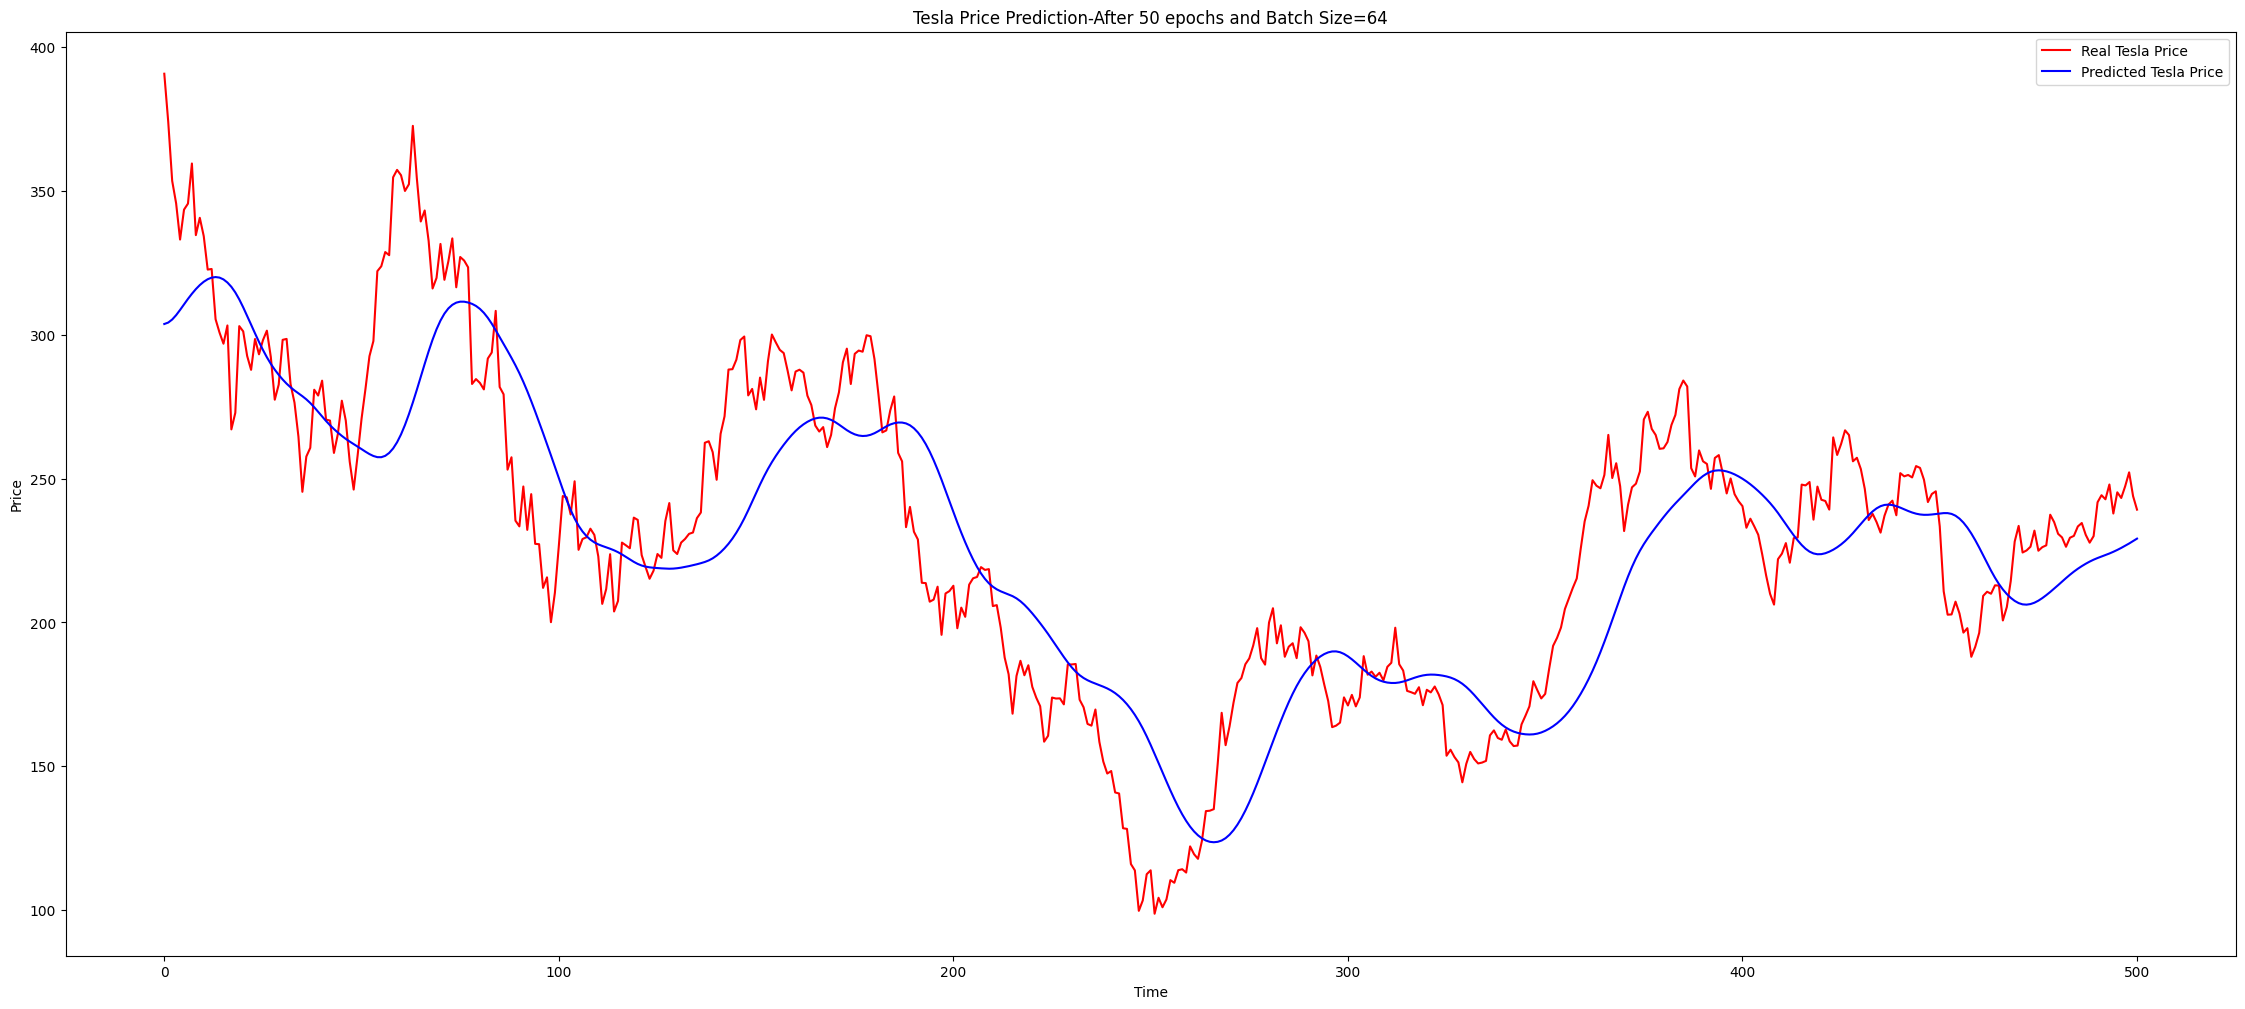

In [150]:
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Real Tesla Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Tesla Price')
plt.title('Tesla Price Prediction-After 50 epochs and Batch Size=64')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [151]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

df_result = pd.DataFrame()
df_result['true']= y_test
df_result['predicted']= y_pred

print(df_result)
print(f"mse: {mse:.2f}")
print(f"mae: {mae:.2f}")
print(len(y_pred))



print(y_test[0:10])
# mse: 1122.20
# mae: 26.06

#mse 1451
#mae 31.42

#1232
#2810

y_true_binary = (df_result['predicted'].diff().fillna(0) > 0).astype(int)
y_pred_binary = (df_result['true'].diff().fillna(0) > 0).astype(int)

report  = classification_report(y_true_binary, y_pred_binary)
print(report)

           true   predicted
0    390.637333  303.687592
1    373.907322  304.186829
2    353.417332  305.243286
3    345.610661  306.756989
4    333.030674  308.575867
..          ...         ...
496  243.250660  225.898010
497  247.320652  226.643677
498  252.150669  227.429504
499  243.890660  228.262039
500  239.190663  229.124146

[501 rows x 2 columns]
mse: 859.99
mae: 22.86
501
[390.637333 373.907322 353.417332 345.610661 333.030674 343.417332
 345.510655 359.450657 334.564    340.580662]
              precision    recall  f1-score   support

           0       0.58      0.51      0.54       280
           1       0.47      0.54      0.50       221

    accuracy                           0.52       501
   macro avg       0.52      0.53      0.52       501
weighted avg       0.53      0.52      0.52       501

